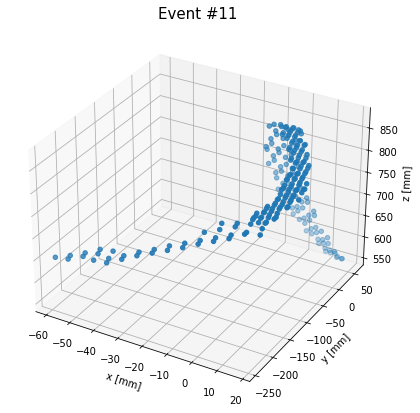

In [1]:
import numpy as np
import pandas as pd
%run utils.ipynb

In [2]:
df = load_sim_data('DataFiles/Mg22_alphaalpha_digiSim.h5')

In [22]:
# Preprocessing Raw data in order to get higher level features
avg_x_reac = []
avg_y_reac = []
avg_z_reac = []
sum_charge_reac = []
npads_reac = []

avg_x_beam = []
avg_y_beam = []
avg_z_beam = []
sum_charge_beam = []
npads_beam = []

for e in df:
    
    if(e.label == 0):
        
        avg_x_reac.append(np.mean(e.x))
        avg_y_reac.append(np.mean(e.y))
        avg_z_reac.append(np.mean(e.z))
        sum_charge_reac.append(np.sum(e.q))
        npads_reac.append(len(e.x))

    if(e.label == 1):
        
        avg_x_beam.append(np.mean(e.x))
        avg_y_beam.append(np.mean(e.y))
        avg_z_beam.append(np.mean(e.z))
        sum_charge_beam.append(np.sum(e.q))
        npads_beam.append(len(e.x))
        
avgx_preprocessed = avg_x_reac + avg_x_beam
avgy_preprocessed = avg_y_reac + avg_y_beam
avgz_preprocessed = avg_z_reac + avg_z_beam
total_sum_charge_preprocessed = sum_charge_reac + sum_charge_beam
npads_preprocessed = npads_reac + npads_beam

preproc_label=np.zeros(len(avg_x_reac)).tolist() + np.ones(len(avg_x_beam)).tolist()

# Min.Max scaling
avgx_preprocessed = (avgx_preprocessed - np.min(avgx_preprocessed)) / (np.max(avgx_preprocessed) - np.min(avgx_preprocessed))
avgy_preprocessed = (avgy_preprocessed - np.min(avgy_preprocessed)) / (np.max(avgy_preprocessed) - np.min(avgy_preprocessed))
avgz_preprocessed = (avgz_preprocessed - np.min(avgz_preprocessed)) / (np.max(avgz_preprocessed) - np.min(avgz_preprocessed))
total_sum_charge_preprocessed = (total_sum_charge_preprocessed - np.min(total_sum_charge_preprocessed))  / (np.max(total_sum_charge_preprocessed) - np.min(total_sum_charge_preprocessed))
npads_preprocessed = (npads_preprocessed - np.min(npads_preprocessed)) / (np.max(npads_preprocessed) - np.min(npads_preprocessed))


preprocessed_dataset = pd.DataFrame({'avgx'     : avgx_preprocessed, 
                                     'avgy'     : avgy_preprocessed,
                                     'avgz'     : avgz_preprocessed,
                                     'totalSum' : total_sum_charge_preprocessed,
                                     'npads'    : npads_preprocessed,
                                     'label'    : preproc_label
                                    })
print(preprocessed_dataset)
from sklearn.utils import shuffle
preprocessed_dataset = shuffle(preprocessed_dataset)
train_set        = preprocessed_dataset[:int(0.8*1995)].drop('label', 1)
train_label      = preprocessed_dataset[:int(0.8*1995)]['label']
validation_set   = preprocessed_dataset[int(0.8*1995):].drop('label', 1)
validation_label = preprocessed_dataset[int(0.8*1995):]['label']

          avgx      avgy      avgz  totalSum     npads  label
0     0.510129  0.528006  0.936597  0.043671  0.035573    0.0
1     0.510129  0.528006  0.792331  0.094334  0.035573    0.0
2     0.510129  0.528006  0.898527  0.036576  0.035573    0.0
3     0.510129  0.528006  0.813799  0.030352  0.035573    0.0
4     0.510129  0.528006  0.696726  0.047282  0.035573    0.0
...        ...       ...       ...       ...       ...    ...
1990  0.421935  0.716467  0.238834  0.215346  0.233202    1.0
1991  0.376854  0.538716  0.804801  0.533742  0.355731    1.0
1992  0.680284  0.735452  0.120544  0.385861  0.616601    1.0
1993  0.487901  0.466157  0.190958  0.040024  0.073123    1.0
1994  0.486130  0.544719  0.490442  0.275555  0.136364    1.0

[1995 rows x 6 columns]


## Autoencoder

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder1 (Dense)             (None, 10)                60        
_________________________________________________________________
Encoder2 (Dense)             (None, 2)                 22        
_________________________________________________________________
Decoder1 (Dense)             (None, 10)                30        
_________________________________________________________________
Decoder2 (Dense)             (None, 5)                 55        
Total params: 167
Trainable params: 167
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
25/25 [==============================] - 0s 4ms/step - loss: 0.2487 - mean_squared_error: 0.2487 - val_loss: 0.1986 - val_mean_squared_error: 0.1986
Epoch 2/300
25/25 [==============================] - 0s 1ms/step - loss: 0.1847 - mean_square

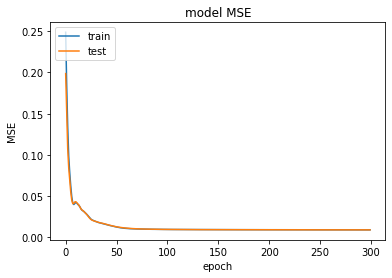

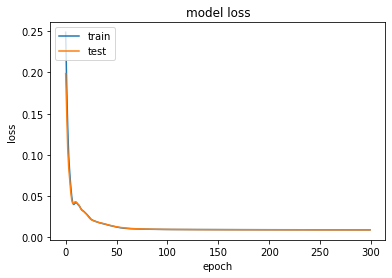

In [14]:
# Building autoencoder model
autoencoder = keras.Sequential()
autoencoder.add(keras.Input(shape=(5,)))

# Encoder Part
autoencoder.add(layers.Dense(10,activation='tanh', name='Encoder1'))
autoencoder.add(layers.Dense(2,activation='tanh', name='Encoder2'))

# Decoder Part
autoencoder.add(layers.Dense(10,activation='tanh', name='Decoder1'))
autoencoder.add(layers.Dense(5,activation='tanh', name='Decoder2'))

autoencoder.summary()

# Compiling Model
autoencoder.compile(
        optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.99, beta_2=0.999),
        loss      = keras.losses.MeanSquaredError(),
        metrics   = [keras.metrics.MeanSquaredError()]
    )

# Training The Model

history = autoencoder.fit(
                            train_set,
                            train_set,
                            validation_data = (validation_set,validation_set),
                            batch_size=64,
                            epochs=300
                         )

# summarize history for accuracy
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
# Defining Encoder
encoder       = autoencoder.get_layer("Encoder2").output
encoder_model = keras.Model(inputs=autoencoder.input, outputs=encoder)

# Training Clustering k-Means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=30).fit(encoder_model.predict(train_set))


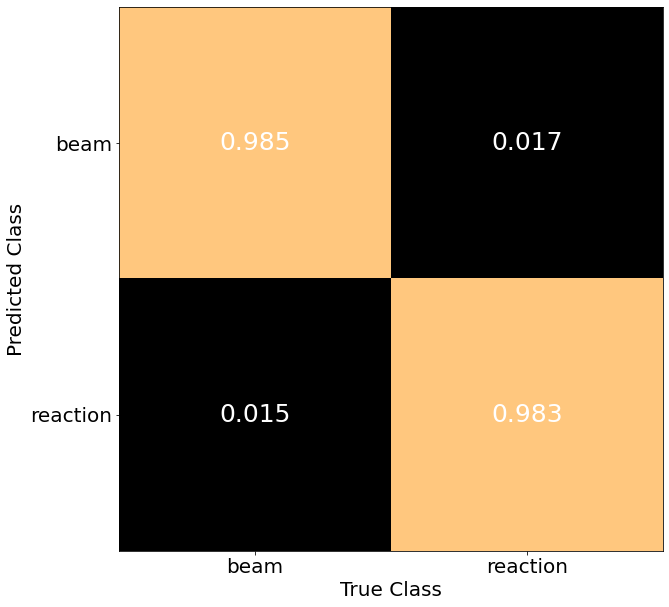

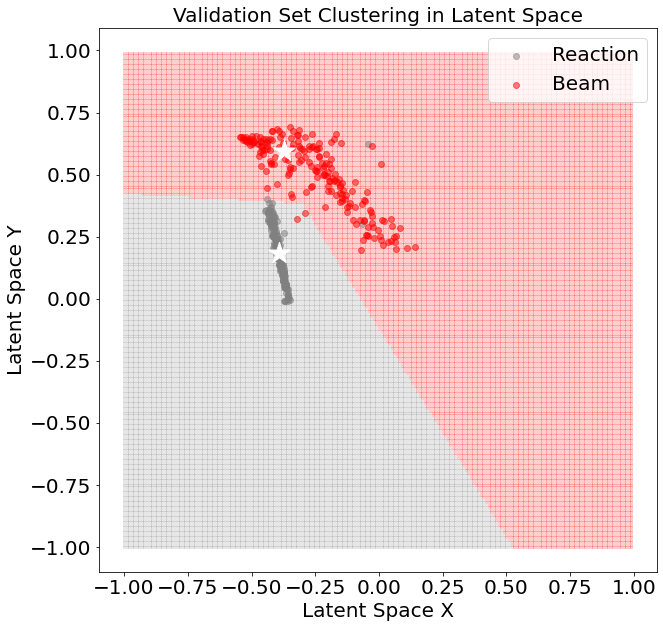

In [18]:
x_latent = encoder_model.predict(validation_set)[:, 0]
y_latent = encoder_model.predict(validation_set)[:, 1]

list_reac_x = []
list_reac_y = []
list_beam_x = []
list_beam_y = []

for xl,yl,l in zip(x_latent, y_latent, validation_label) :
    
        if(l==0):
            
            list_reac_x.append(xl)
            list_reac_y.append(yl)
    
        else:
            
            list_beam_x.append(xl)
            list_beam_y.append(yl)
            
centroids = kmeans.cluster_centers_

# Draw Background class regions
points = np.random.uniform(-1,1,(10,2))

p_reac_x = []
p_reac_y = []
p_beam_x = []
p_beam_y = []

for x in np.arange(-1, 1, 0.01):
    
    for y in np.arange(-1, 1, 0.01):
    
        p = np.array([x,y], dtype=np.float32).reshape(1,-1)

        if(kmeans.predict(p) == 0):

            p_reac_x.append(p[0][0])
            p_reac_y.append(p[0][1])
            
        else:            
            
            p_beam_x.append(p[0][0])
            p_beam_y.append(p[0][1])


# Scoring Clustering Results
l00 = 0
l01 = 0
l10 = 0
l11 = 0

for xl, yl,l in zip(x_latent, y_latent, validation_label):
    
    predicted_label = kmeans.predict(np.array([xl,yl], dtype=np.float32).reshape(1,-1))
    
    if(predicted_label == 0 and l == 0):
        l00 += 1
    if(predicted_label == 0 and l == 1):
        l01 += 1
    if(predicted_label == 1 and l == 0):
        l10 += 1
    if(predicted_label == 1 and l == 1):
        l11 += 1
    
# Compute the Confusion Matrix
cm = np.matrix([[l00/(l00+l10),l01/(l11+l01)],[l10/(l10+l00),l11/(l01+l11)]])
    
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(cm, cmap='copper')

ax.set_xticks(np.arange(len(['beam', 'reaction'])))
ax.set_yticks(np.arange(len(['beam', 'reaction'])))

ax.set_xticklabels(['beam', 'reaction'])
ax.set_yticklabels(['beam', 'reaction'])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylabel("Predicted Class", fontsize=20)
plt.xlabel("True Class", fontsize=20)

for i in range(len(['beam','reaction'])):
    for j in range(len(['beam', 'reaction'])):
        text = ax.text(j, i, np.round(cm[i, j],3),
                       ha="center", va="center", color="w", fontsize=25)

# Visualizing Results
fig = plt.figure(figsize=(10,10))
plt.scatter(p_reac_x, p_reac_y, color='gray', marker='s', s=5, alpha=0.15)
plt.scatter(p_beam_x, p_beam_y, color='red', marker='s', s=5, alpha=0.15)
plt.scatter(list_reac_x, list_reac_y, color='gray', label='Reaction', alpha=0.5)
plt.scatter(list_beam_x, list_beam_y, color='red', label='Beam', alpha=0.5)
plt.scatter([centroids[0][0]],[centroids[0][1]], marker='*', s=500, c='white')
plt.scatter([centroids[1][0]],[centroids[1][1]], marker='*', s=500, c='white')

plt.legend(fontsize=20);
plt.title("Validation Set Clustering in Latent Space", fontsize=20);
plt.xticks(fontsize=20);
plt.xlabel("Latent Space X", fontsize=20);
plt.yticks(fontsize=20);
plt.ylabel("Latent Space Y", fontsize=20);

In [21]:
validation_set

,avgx,avgy,avgz,totalSum,npads
851,0.510129,0.528006,0.948906,0.025234,0.035573
1292,0.359123,0.614365,0.182880,0.130658,0.179842
1423,0.501535,0.546401,0.227541,0.055565,0.039526
395,0.510129,0.528006,0.752543,0.103193,0.035573
1566,0.634540,0.509937,0.321701,0.195101,0.164032
...,...,...,...,...,...
325,0.510129,0.528006,0.872479,0.044839,0.035573
1585,0.472311,0.176366,0.218353,0.294947,0.369565
436,0.510129,0.528006,0.988837,0.042057,0.035573
1492,0.606873,0.567225,0.216513,0.073202,0.112648
